## Load Libraries

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, TargetEncoder, SplineTransformer, FunctionTransformer, Binarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from pathlib import Path
import os
from sklearn import set_config
from imblearn.over_sampling import SMOTE
import sys
path = Path.cwd().parent

# Absolute path to your package
sys.path.append(os.path.join(path))

from utils import convert_months_to_categorical, calculate_score, ClipValues, SinePreprocess

# Enable pandas output globally
set_config(transform_output="pandas")

## Load data

In [2]:

train_file_path = os.path.join(path, "raw", "train.csv")
test_file_path = os.path.join(path, "raw", "test.csv")

In [3]:
original_train_df = pd.read_csv(train_file_path, index_col=0)
test_df = pd.read_csv(test_file_path, index_col=0)

In [4]:
y_var = "y"
categorical_variables = original_train_df.select_dtypes(include="object").columns.to_list()
numerical_variables = (
    original_train_df
    .select_dtypes(exclude="object")
    .columns
    .drop(
        labels=["y"]
    )
    .to_list()
)

## Train val split

In [5]:
train_df, val_df = train_test_split(original_train_df, test_size=0.3)

## Preprocessing and train pipeline

In [172]:
power_pipeline = Pipeline(
    [
        ("clip", ClipValues(quantile_range=(0.25, 0.75))),
        ("power_transform", PowerTransformer("yeo-johnson", standardize=True)),
        ("splines", SplineTransformer(n_knots=10, knots="quantile"))
    ],
)

one_hot_pipeline = Pipeline(
    [
        ("one_hot", OneHotEncoder(drop="first", sparse_output=False))
    ]
)

previous_binarizer = Pipeline(
    [
        ("binarizer", Binarizer(threshold=0.01))
    ]
)

target_encoder = TargetEncoder()
sin_preprocess = SinePreprocess(
    {
        "day": 31,
        "month": 12
    }
)

age_scaler = SplineTransformer(n_knots=5, knots="quantile")

def interactions_function(X: pd.DataFrame) -> pd.DataFrame:
    X_df = X.copy()
    for col in X_df.columns:
        if col.startswith("duration"):
            X_df[f"{col}_times_poutcome_unknown"] = X_df[col] * X["poutcome_unknown"]
            X_df[f"{col}_times_contact_unknown"] = X_df[col] * X["contact_unknown"]
            X_df[f"{col}_times_contact_telephone"] = X_df[col] * X["contact_telephone"]
            # X_df[f"{col}_times_job_unknown"] = X_df[col] * X["job_unknown"]
            # X_df[f"{col}_times_job_housemaid"] = X_df[col] * X["job_housemaid"]
            X_df[f"{col}_times_default_yes"] = X_df[col] * X["default_yes"]
            X_df[f"{col}_times_housing_yes"] = X_df[col] * X["housing_yes"]
            X_df[f"{col}_times_default_yes_housing_yes"] = X_df[col] * X["default_yes"] * X["housing_yes"]
        if col.startswith("balance") and not col.startswith("balance_by"):
            X_df[f"{col}_times_poutcome_unknown"] = X_df[col] * X["poutcome_unknown"]
            # X_df[f"{col}_times_contact_unknown"] = X_df[col] * X["contact_unknown"]
            # X_df[f"{col}_times_contact_telephone"] = X_df[col] * X["contact_telephone"]
            X_df[f"{col}_times_default_yes"] = X_df[col] * X["default_yes"]
            X_df[f"{col}_times_housing_yes"] = X_df[col] * X["housing_yes"]
            X_df[f"{col}_times_default_yes_housing_yes"] = X_df[col] * X["default_yes"] * X["housing_yes"]
            # X_df[f"{col}_times_job_unknown"] = X_df[col] * X["job_unknown"]
    return X_df
            

interactions_transformer = FunctionTransformer(interactions_function)

preprocessing_pipeline_0 = ColumnTransformer(
    [
        ("numerical", power_pipeline, ["balance", "duration", "campaign", "pdays"]),
        ("binarizer", previous_binarizer, ["previous"]),
        ("to_one_hot", one_hot_pipeline, ["default", "housing", "loan", "poutcome", "education", "contact", "job", "marital"]),
        ("target_encoder", target_encoder, ["month"]),
        ("sine_preproces", sin_preprocess, ["day"]),
        ("age", age_scaler, ["age", "balance_by_duration"])
    ],
    verbose_feature_names_out=False
)

pipeline = Pipeline(
    [
        ("month_transform_to_categorical", FunctionTransformer(
            convert_months_to_categorical, 
            validate=False,
        )),
        ("preprocess_0", preprocessing_pipeline_0),
        # ("interactions", interactions_transformer),
        # ("smote", SMOTE(random_state=42)),
        ("logistic_regression", LogisticRegression(class_weight="balanced", max_iter=300, penalty=None))
    ]
)

In [173]:
fitted_pipeline = pipeline.fit(train_df, train_df[y_var])

## Evaluation

In [174]:
# train_df_preprocessed = fitted_pipeline.transform(train_df)
train_pred_probs = fitted_pipeline.predict_proba(train_df)[:, 1]
calculate_score(train_df["y"], train_pred_probs)

{'auc': np.float64(0.9487825381830789),
 'accuracy': 0.8645847619047619,
 'f1': 0.6189166733671035}

In [175]:
# train_df_preprocessed = fitted_pipeline.transform(train_df)
val_pred_probs = fitted_pipeline.predict_proba(val_df)[:, 1]
calculate_score(val_df["y"], val_pred_probs)

{'auc': np.float64(0.9480095475755184),
 'accuracy': 0.8652666666666666,
 'f1': 0.6202127259743676}

## Shap

In [128]:
import shap
import matplotlib.pyplot as plt

In [129]:
shap.initjs()
sample_df = train_df.sample(10000, random_state=42)
X_shap = fitted_pipeline[:-1].transform(sample_df)
y = fitted_pipeline[-1].predict_proba(X_shap)
explainer = shap.LinearExplainer(fitted_pipeline[-1], X_shap)
shap_values = explainer(X_shap)


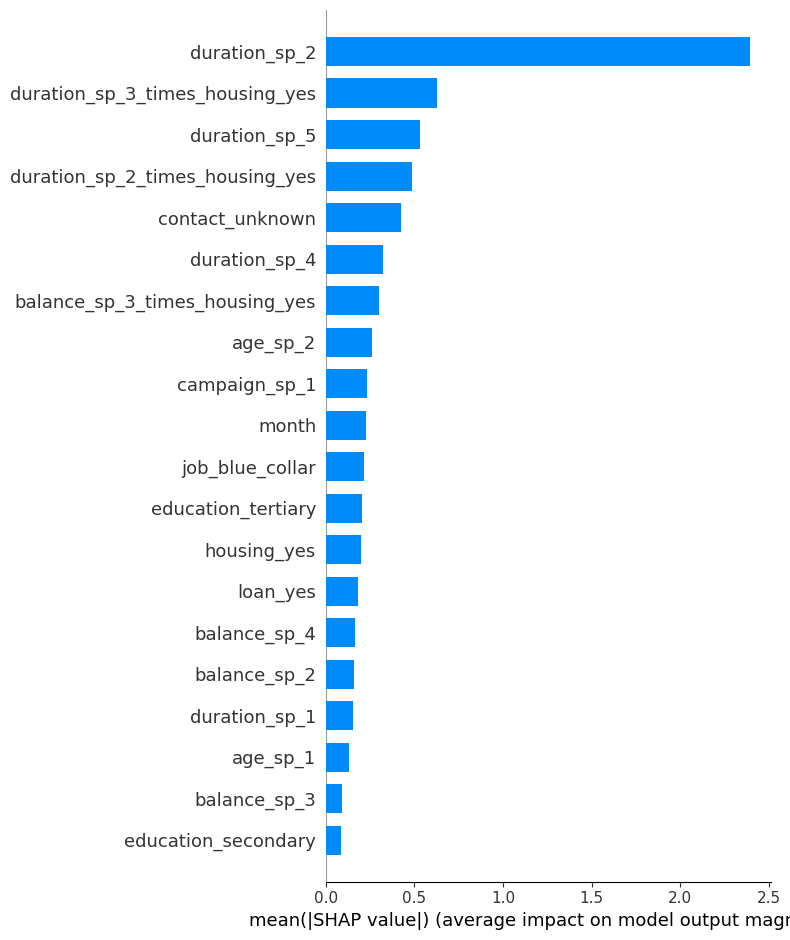

In [130]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")

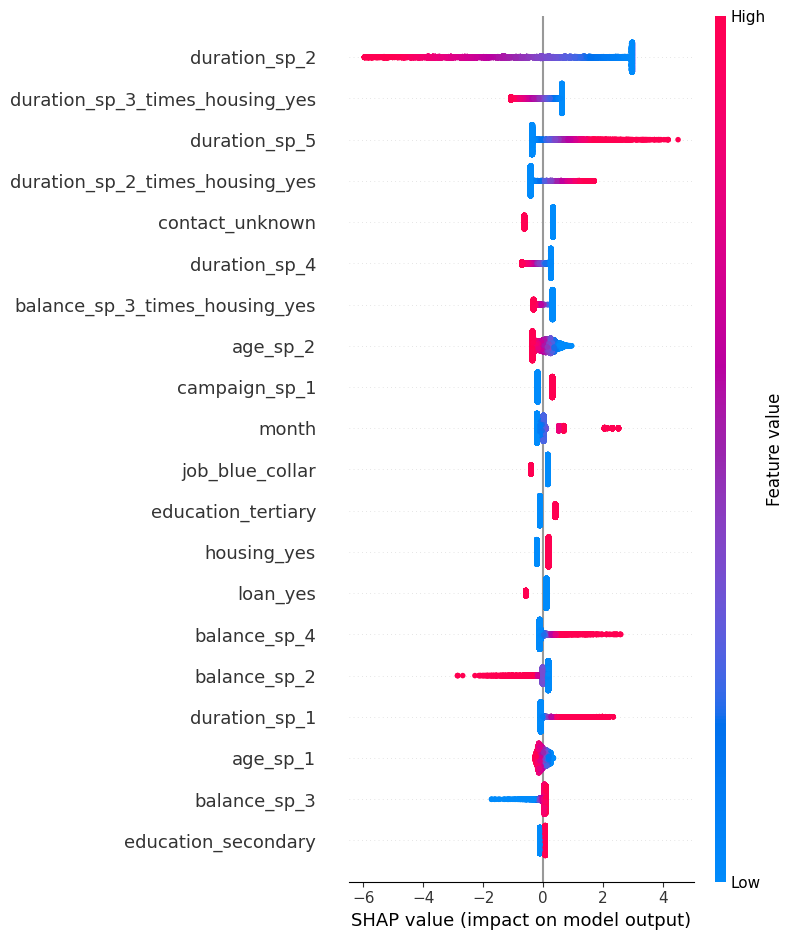

In [131]:
shap.summary_plot(shap_values, X_shap)

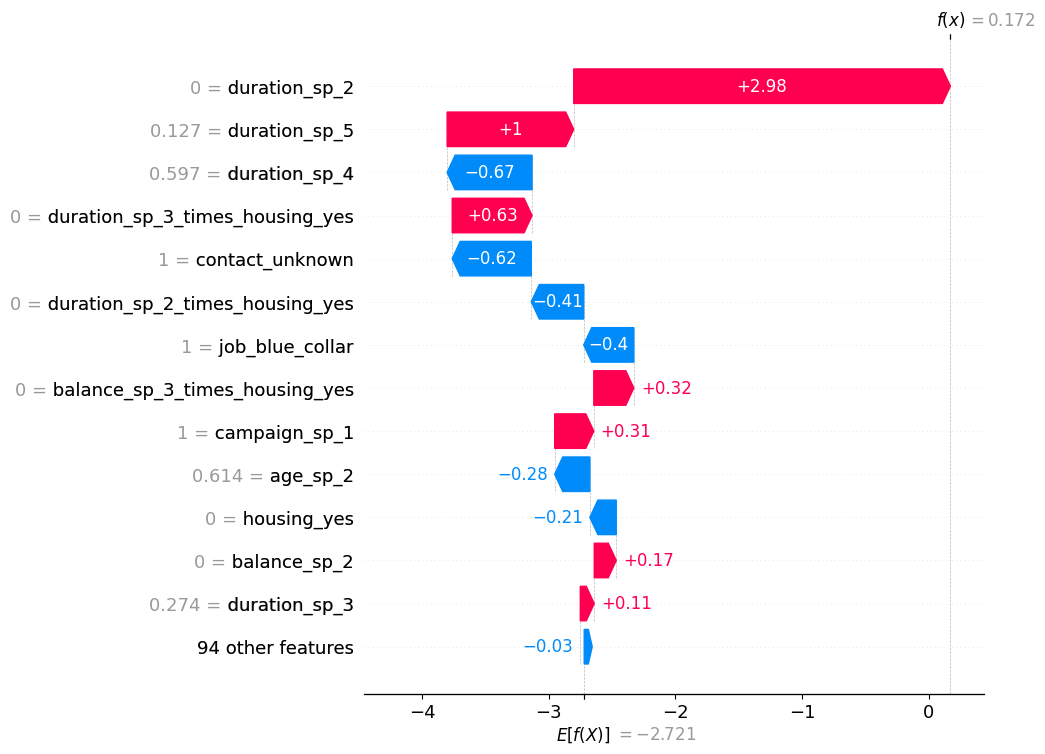

In [132]:
shap.plots.waterfall(shap_values[0], max_display=14)

In [133]:
from sklearn.inspection import partial_dependence
import numpy as np

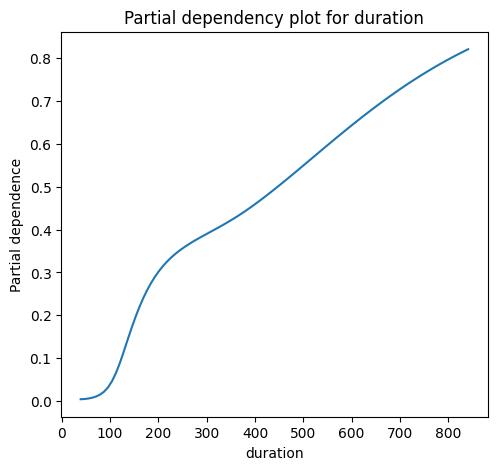

In [139]:
col = "duration"
fig = plt.figure(figsize=(5.5, 5))
pdp = partial_dependence(fitted_pipeline, train_df.sample(1000, random_state=42), col)

plt.plot(pdp["grid_values"][0], pdp["average"][0])
plt.title(f"Partial dependency plot for {col}")
plt.xlabel(f"{col}")
plt.ylabel("Partial dependence")
plt.show()

## Errors analysis

In [135]:
errors_df = val_df.copy()
errors_df["pred"] = fitted_pipeline.predict(val_df)
errors_df["pred_proba"] = fitted_pipeline.predict_proba(val_df)[:, 1]
errors_df["pred_log_proba"] = fitted_pipeline.predict_log_proba(val_df)[:, 1]
errors_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pred,pred_proba,pred_log_proba
id,,,,,,,,,,,,,,,,,,,,
672429,34,blue-collar,married,secondary,yes,33,yes,no,cellular,31,jul,8,17,-1,0,unknown,0,0,0.017129,-4.066975
436684,35,technician,married,secondary,no,5553,yes,no,cellular,7,sep,589,2,-1,0,unknown,0,1,0.964719,-0.035918
206681,30,technician,single,secondary,no,783,yes,no,cellular,29,jan,177,1,-1,0,unknown,0,0,0.242113,-1.418350
383892,35,technician,married,secondary,yes,0,no,no,cellular,11,aug,117,4,-1,0,unknown,0,0,0.010664,-4.540852
356473,48,entrepreneur,divorced,tertiary,no,942,no,no,cellular,17,nov,641,4,-1,0,unknown,1,1,0.742557,-0.297655


In [136]:
errors_df[
    ( errors_df["y"] != errors_df["pred"] ) &
    ( errors_df["month"] == "may" )
].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pred,pred_proba,pred_log_proba
id,,,,,,,,,,,,,,,,,,,,
224516,29,management,single,tertiary,no,16992,yes,no,cellular,6,may,239,1,-1,0,unknown,0,1,0.556211,-0.586608
492570,28,unemployed,married,secondary,no,1303,yes,yes,unknown,30,may,686,5,-1,0,unknown,1,0,0.327029,-1.117707
95483,41,blue-collar,married,secondary,no,799,yes,no,cellular,18,may,270,2,-1,0,unknown,1,0,0.113380,-2.177011
563709,37,unemployed,single,secondary,no,489,yes,no,cellular,14,may,955,1,-1,0,unknown,0,1,0.916374,-0.087331
722567,35,admin.,single,secondary,no,-32,yes,no,cellular,12,may,787,1,370,1,failure,0,1,0.907987,-0.096525


In [137]:
import gower
columns = errors_df.select_dtypes(exclude="object").columns.drop(["y", "pred", "pred_proba", "pred_log_proba"])
to_gower = errors_df[
    ( errors_df["month"] == "may" )
    & ( errors_df["marital"] == "divorced" )
    & ( errors_df["job"] == "admin." )
    & ( errors_df["education"] == "secondary" )
    # & ( errors_df["housing"] == "yes" )
    & ( errors_df["loan"] == "yes" )
    # & ( errors_df["poutcome"] == "other" )
]
indices = gower.gower_topn(
    to_gower.loc[[372890], columns].astype(float),
    to_gower.loc[: , columns].astype(float),
    n = 15
)
to_gower.iloc[indices["index"]]
# gower.gower_matrix(errors_df[errors_df.columns[:-4]])
# errors_df.loc[476313, errors_df.columns[:-4]]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pred,pred_proba,pred_log_proba
id,,,,,,,,,,,,,,,,,,,,
372890,39,admin.,divorced,secondary,no,72,yes,yes,cellular,11,may,567,1,285,2,other,0,1,0.597676,-0.514707
489206,38,admin.,divorced,secondary,no,-247,yes,yes,cellular,11,may,633,1,305,4,failure,1,1,0.599265,-0.512051
641292,45,admin.,divorced,secondary,no,0,yes,yes,cellular,12,may,506,2,292,1,failure,0,0,0.344970,-1.064297
703827,41,admin.,divorced,secondary,no,-212,yes,yes,cellular,11,may,489,2,347,1,failure,0,0,0.293574,-1.225624
226824,35,admin.,divorced,secondary,no,769,yes,yes,cellular,6,may,579,1,344,1,failure,0,1,0.650682,-0.429734
569187,32,admin.,divorced,secondary,no,-416,yes,yes,cellular,12,may,519,1,350,4,failure,0,0,0.437308,-0.827117
319161,41,admin.,divorced,secondary,no,-212,yes,yes,cellular,12,may,154,1,350,2,failure,0,0,0.044792,-3.105737
365191,49,admin.,divorced,secondary,no,-212,yes,yes,cellular,11,may,469,2,350,1,failure,0,0,0.276682,-1.284885
510353,40,admin.,divorced,secondary,no,-98,yes,yes,cellular,6,may,142,2,287,4,failure,0,0,0.027921,-3.578388


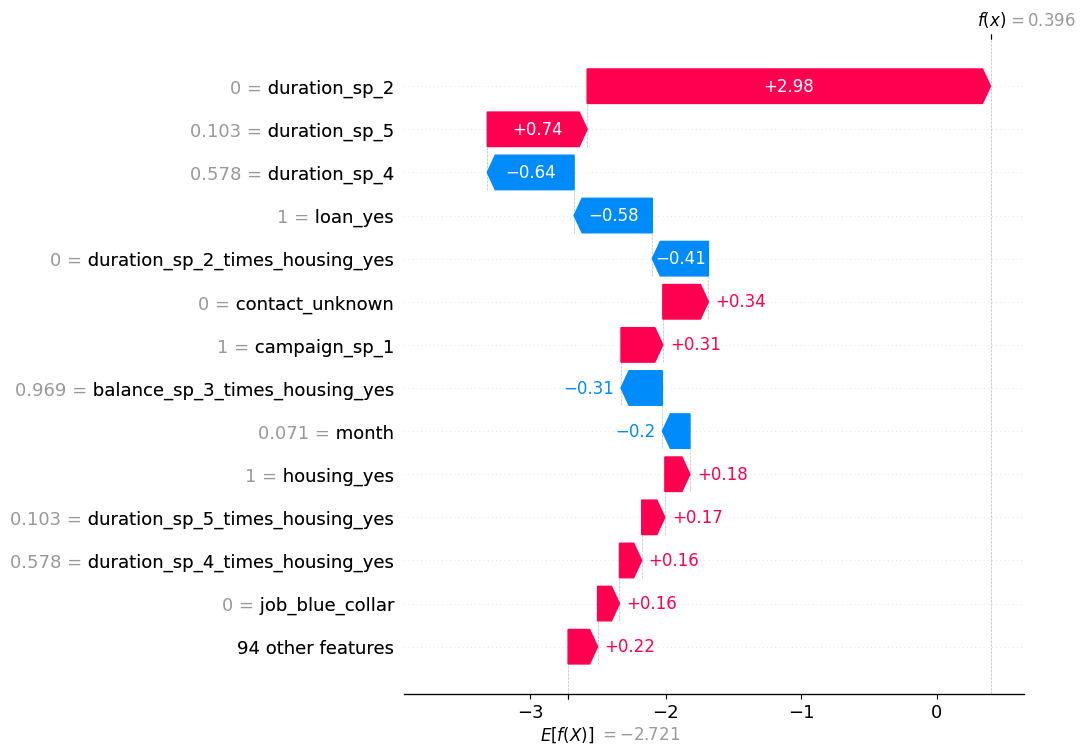

In [138]:
# shap
X_shap = fitted_pipeline[:-1].transform(errors_df.loc[[372890]])
# y = fitted_pipeline[-1].predict_proba(X_shap)
# explainer = shap.LinearExplainer(fitted_pipeline[-1], X_shap)
shap_values = explainer(X_shap)
shap.plots.waterfall(shap_values[0], max_display=14)

## Submission

In [176]:
test_pred_probs = fitted_pipeline.predict_proba(test_df)
test_pred_probs

array([[0.83170857, 0.16829143],
       [0.28342761, 0.71657239],
       [0.99684739, 0.00315261],
       ...,
       [0.09943248, 0.90056752],
       [0.9720134 , 0.0279866 ],
       [0.59181939, 0.40818061]], shape=(250000, 2))

In [177]:
submission_lr_balanced = test_df[[]]
submission_lr_balanced = submission_lr_balanced.copy()
submission_lr_balanced.loc[:, "y"] = test_pred_probs[:, 1]
submission_lr_balanced.to_csv("submission_lr.csv")